In [16]:
#Adjustments AI 
#Sample data creator


In [14]:
#Shared common config
SpecialFields=["AdjustmentType","AdjustmentName","AdjustedField"]
AuditFields=["OldVal","NewVal"]
SampleFields=["CustomerID","CustomerType","RiskCategory","IsDefaulted","CountryCode"]
NumericFields=["Drawn","Undrawn"]
RatioFields=["PD"]
AdjustmentTypes=["Amend"]
AdjustmentNames=["Noise_6f","Noise_22d","Noise_116z","Noise_256n","Noise_128x","Noise_19b"]
AdjustedFields=SampleFields
CustomerID=["CUST238947","CUST563201","CUST981372","CUST450896","CUST712035","CUST103289","CUST665428","CUST359147","CUST804231","CUST192654"]
CustomerType=["Retail","Corporate","SME"]
RiskCategory=["Low","Medium","High"]
IsDefaulted=["0","1"]
CountryCode=["US","GB","DE"]
FieldMapping={"CustomerID":CustomerID,"CustomerType":CustomerType,"RiskCategory":RiskCategory,"IsDefaulted":IsDefaulted,"CountryCode":CountryCode}

#Define adjustment rules
AdjustmentRules=[]
AdjustmentRules.append([[{"CustomerType":"Corporate"},{"RiskCategory":"High"}],["PD",0.75,"Market Downturn"]])
AdjustmentRules.append([[{"RiskCategory":"High"},{"IsDefaulted":"1"}],["CustomerType","Debt Recovery","Defaulting Cleanup"]])
AdjustmentRules.append([[{"CountryCode":"GB"},{"IsDefaulted":"0"}],["RiskCategory","Medium","BREXIT"]])
AdjustmentRules.append([[{"CountryCode":"GB"},{"IsDefaulted":"1"}],["RiskCategory","High","BREXIT_DEFAULTED"]])
AdjustmentRules.append([[{"CountryCode":"DE"},{"CustomerType":"Retail"}],["RiskCategory","Medium","German Retail Downturn"]])
AdjustmentRules.append([[{"CustomerType":"Corporate"},{"CountryCode":"US"}],["PD",0.75,"US Corporate Crunch"]])


In [15]:
#Generate random data with Adjustment rules applied
import pandas as pd
import numpy as np

#Sample Data Generator
records=20000

#Hide warmings from pandas
pd.options.mode.chained_assignment = None  # default='warn'

def GetRandomFieldValue(field):
    return np.random.choice(FieldMapping[field],1)[0]

#Checks if this row matches any adjustment rule, if so returns the [{fieldToUpdate:NewValue},AdjustmentComment]
def ValidateGetAdjustmentRule(row):
    for rule in AdjustmentRules:
        criteria=rule[0]
        adjustment=rule[1]

        #Check all criteria match
        allMatch=True
        for crit in criteria:
            #Split crit dictionary into key and value
            critField=list(crit.keys())[0]
            critValue=crit[critField]

            #Check if row matched
            if row[critField]!=critValue:
                allMatch=False
        
        if allMatch:
            return allMatch,adjustment
    
    return False,[]


df=pd.DataFrame(columns=SampleFields+SpecialFields+AuditFields)
for mapping in FieldMapping:
    df[mapping]=np.random.choice(FieldMapping[mapping],records)
df["AdjustmentType"]=np.random.choice(AdjustmentTypes,records)
df["AdjustmentName"]=np.random.choice(AdjustmentNames,records)

#Adjusted field------------------------------------------------------------------------
df["AdjustedField"]=np.random.choice(AdjustedFields,records)
#df["AdjustedField"]="CustomerType"

for field in NumericFields:
    #Insert new column after first 1
    df[field]=np.random.randint(1000000, size=records)
for field in RatioFields:
    df[field]=np.random.randint(100, size=records)/100

#Add in audit fields
df["OldVal"]=np.nan
df["NewVal"]=np.nan

#Loop over each row and generate a new value for Oldval based on field
for index, row in df.iterrows():
    adjField=row["AdjustedField"]

    #Check if this row matches any adjustment rule
    matchesRule,rule = ValidateGetAdjustmentRule(row)

    #APPLY ADJUSTMENTS--------------------------------------
    if adjField not in NumericFields and adjField not in RatioFields:

        if matchesRule:
            
            #Split rule dictionary into key and value
            ruleTarget=rule[0]
            ruleValue=rule[1]
            ruleComment=rule[2]
            df["AdjustmentName"][index]=ruleComment
            df["AdjustedField"][index]=ruleTarget
            df["NewVal"][index]=ruleValue
        else:
            #Random "noise" adjustments
            #df["OldVal"][index]=row[adjField]
            df["NewVal"][index]=GetRandomFieldValue(adjField)

# #Reshuffle the numeric fields to the start
df=df.reindex(columns=SpecialFields+NumericFields+RatioFields+SampleFields+AuditFields)

#Remove OldVal Field
df=df.drop(columns=["OldVal"])

# #Write to CSV file
df.to_csv("SampleData.csv",index=False)
df


,AdjustmentType,AdjustmentName,AdjustedField,Drawn,Undrawn,PD,CustomerID,CustomerType,RiskCategory,IsDefaulted,CountryCode,NewVal
0,Amend,US Corporate Crunch,PD,882892,800262,0.33,CUST103289,Corporate,Medium,0,US,0.65
1,Amend,US Corporate Crunch,PD,467986,108095,0.08,CUST103289,Corporate,Medium,1,US,0.65
2,Amend,Market Downturn,PD,184199,238031,0.77,CUST563201,Corporate,High,0,DE,0.75
3,Amend,Noise_256n,CustomerType,359894,504038,0.93,CUST450896,SME,Low,0,US,Retail
4,Amend,Market Downturn,PD,268692,429151,0.95,CUST804231,Corporate,High,0,GB,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...
19995,Amend,US Corporate Crunch,PD,78508,356018,0.55,CUST712035,Corporate,Medium,0,US,0.65
19996,Amend,BREXIT,RiskCategory,723949,714063,0.96,CUST665428,Corporate,Low,0,GB,Medium
19997,Amend,Noise_116z,IsDefaulted,228993,16479,0.50,CUST665428,SME,High,0,DE,0
19998,Amend,Market Downturn,PD,286786,371799,0.34,CUST450896,Corporate,High,0,DE,0.75


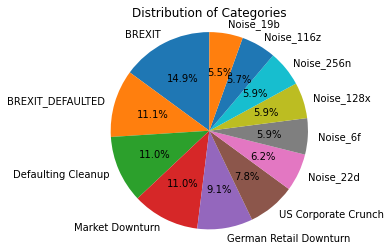

In [16]:
import matplotlib.pyplot as plt
# Replace 'Category' with the field you want to visualize
frequency = df['AdjustmentName'].value_counts()

# Plot the pie chart
plt.pie(frequency, labels=frequency.index, autopct='%1.1f%%', startangle=90)

# Add a title
plt.title('Distribution of Categories')

# Equal aspect ratio ensures the pie chart is circular
plt.axis('equal')

#Make background white
plt.rcParams['axes.facecolor'] = 'white'

#Make background solid
plt.rcParams['axes.edgecolor'] = 'black'

# Display the chart
plt.show()


3

In [4]:
len(df["NewVal"].unique())

22